# Saving a bear classifier Model

> This notebook is following the second lesson in the [fast ai Practical Deep Learning for Coders course](https://course.fast.ai/Lessons/lesson2.html)

The resources related are as following:
1. [Lesson 2 lecture](https://www.youtube.com/watch?v=F4tvM4Vb3A0)
2. [Deep Learning for Coders with Fastai and PyTorch: AI Applications Without a PhD Chapter 2](https://github.com/fastai/fastbook/blob/master/02_production.ipynb)
3. [Course notebooks](https://github.com/fastai/course22/blob/master/02-saving-a-basic-fastai-model.ipynb)

In [27]:
#| default_exp bear_classifier

In [28]:
#| hide
from nbdev.showdoc import *

In [29]:
# Suppress only UserWarning
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

**Detect if notebook is running on Kaggle**

It's a good idea to ensure you're running the latest version of any libraries you need.
`!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>

In [30]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    print('Is running on Kaggle.')
    !pip install -Uqq fastai

### The Drivetrain Approach

I found this section very important and wanted to repeat it again from the book.

There are many accurate models that are of no use to anyone, and many inaccurate models that are highly useful. To ensure that your modeling work is useful in practice, you need to consider how your work will be used. In 2012 Jeremy, along with Margit Zwemer and Mike Loukides, introduced a method called *the Drivetrain Approach* for thinking about this issue.

The Drivetrain Approach was described in detail in ["Designing Great Data Products"](https://www.oreilly.com/radar/drivetrain-approach-data-products/). The basic idea is to start with considering your objective, then think about what actions you can take to meet that objective and what data you have (or can acquire) that can help, and then build a model that you can use to determine the best actions to take to get the best results in terms of your objective.

<img src="./images/drivetrain-approach.png" id="drivetrain" caption="The Drivetrain Approach">

Consider a model in an autonomous vehicle: you want to help a car drive safely from point A to point B without human intervention. Great predictive modeling is an important part of the solution, but it doesn't stand on its own; as products become more sophisticated, it disappears into the plumbing. Someone using a self-driving car is completely unaware of the hundreds (if not thousands) of models and the petabytes of data that make it work. But as data scientists build increasingly sophisticated products, they need a systematic design approach.

We use data not just to generate more data (in the form of predictions), but to produce *actionable outcomes*. That is the goal of the Drivetrain Approach. Start by defining a clear *objective*. For instance, Google, when creating their first search engine, considered "What is the user’s main objective in typing in a search query?" This led them to their objective, which was to "show the most relevant search result." The next step is to consider what *levers* you can pull (i.e., what actions you can take) to better achieve that objective. In Google's case, that was the ranking of the search results. The third step was to consider what new *data* they would need to produce such a ranking; they realized that the implicit information regarding which pages linked to which other pages could be used for this purpose. Only after these first three steps do we begin thinking about building the predictive *models*. Our objective and available levers, what data we already have and what additional data we will need to collect, determine the models we can build. The models will take both the levers and any uncontrollable variables as their inputs; the outputs from the models can be combined to predict the final state for our objective.

Let's consider another example: recommendation systems. The *objective* of a recommendation engine is to drive additional sales by surprising and delighting the customer with recommendations of items they would not have purchased without the recommendation. The *lever* is the ranking of the recommendations. New *data* must be collected to generate recommendations that will *cause new sales*. This will require conducting many randomized experiments in order to collect data about a wide range of recommendations for a wide range of customers. This is a step that few organizations take; but without it, you don't have the information you need to actually optimize recommendations based on your true objective (more sales!).

Finally, you could build two *models* for purchase probabilities, conditional on seeing or not seeing a recommendation. The difference between these two probabilities is a utility function for a given recommendation to a customer. It will be low in cases where the algorithm recommends a familiar book that the customer has already rejected (both components are small) or a book that they would have bought even without the recommendation (both components are large and cancel each other out).

As you can see, in practice often the practical implementation of your models will require a lot more than just training a model! You'll often need to run experiments to collect more data, and consider how to incorporate your models into the overall system you're developing. Speaking of data, let's now focus on how to find data for your project.

## Step 1: Download images of bears

It is the same step as in first lesson with is it a bird classifier.

In [31]:
# Skip this cell if you already have dependencies installed
!pip install -Uqq duckduckgo_search > /dev/null
!pip install -Uqq fastai  > /dev/null
!pip install fastdownload  > /dev/null
!pip install ipywidgets > /dev/null

In [32]:
from duckduckgo_search import DDGS 
from fastcore.all import *
from fastai.vision.widgets import *

def search_images(keywords, max_images=150): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

It is a good practice to test each step. So, here we can test 1 bear image.

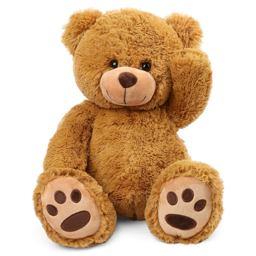

In [33]:
from fastdownload import download_url
from fastai.vision.all import *
from pathlib import Path

teddy_dest = 'teddy_bear.jpg'
teddy_path = Path(teddy_dest)

if not teddy_path.exists():
    download_url(search_images('teddy bear', max_images=1)[0], teddy_dest, show_progress=False)

Image.open(teddy_dest).to_thumb(256,256)

This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [34]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

for o in bear_types:
    dest = (path/o)

    if dest.exists():
        print(f"Directory '{dest}' already exists. Skipping search, download, and resize for '{o}'.")
        continue # Skip the rest of this loop iteration and move to the next search term
        
    dest.mkdir(exist_ok=True, parents=True)
    results = search_images(f'{o} bear')
    download_images(dest, urls=results[:200])
    time.sleep(5)
    resize_images(dest, max_size=400, dest=dest)

Directory 'bears/grizzly' already exists. Skipping search, download, and resize for 'grizzly'.
Directory 'bears/black' already exists. Skipping search, download, and resize for 'black'.
Directory 'bears/teddy' already exists. Skipping search, download, and resize for 'teddy'.


## Step 2: Train our model
Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [35]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

I like Jeremy's approach which he starts training the model quickly and then optimizes for the quick and easy iterations and improvement.
He starts by training the base model and uses then uses that for identifying the data issues in dataset. This approach simplifies the data cleaning by tone.
It makes the data cleaning and augumentation straightforward and intuitive rather than abstract and scary.

That is why in the lecture, he imetiately trains the model with the minimum tricks as the baseline.

In [36]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

There are different resize methods which they influence the image representations. 

By default `Resize` crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. 

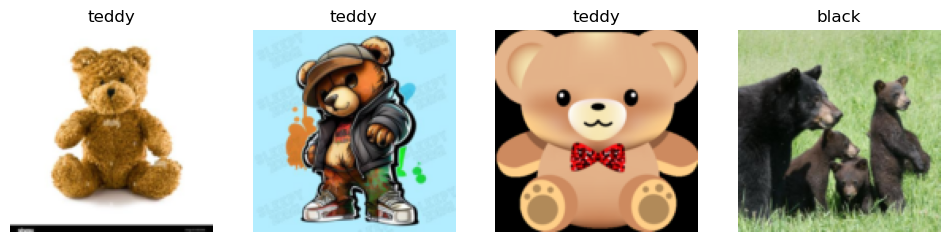

In [37]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Crop))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Alternatively, you can ask fastai to squish/stretch them:

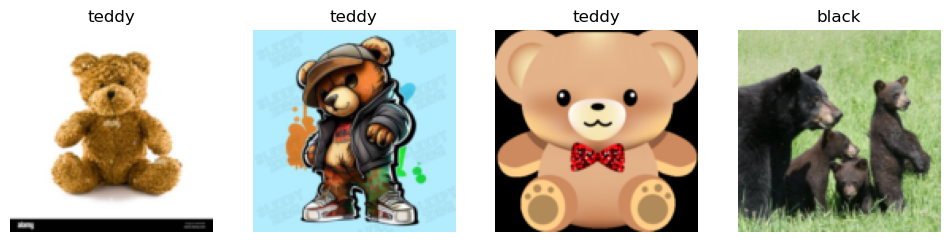

In [38]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Or ask fastai to pad the images with zeros (black):

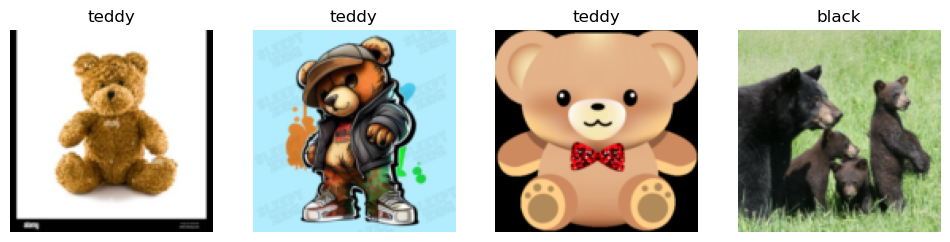

In [39]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time:

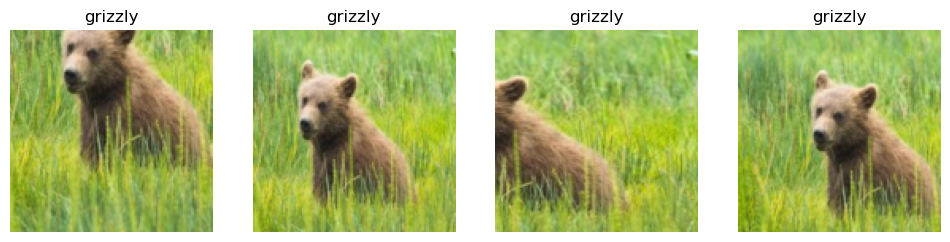

In [40]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation

Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):


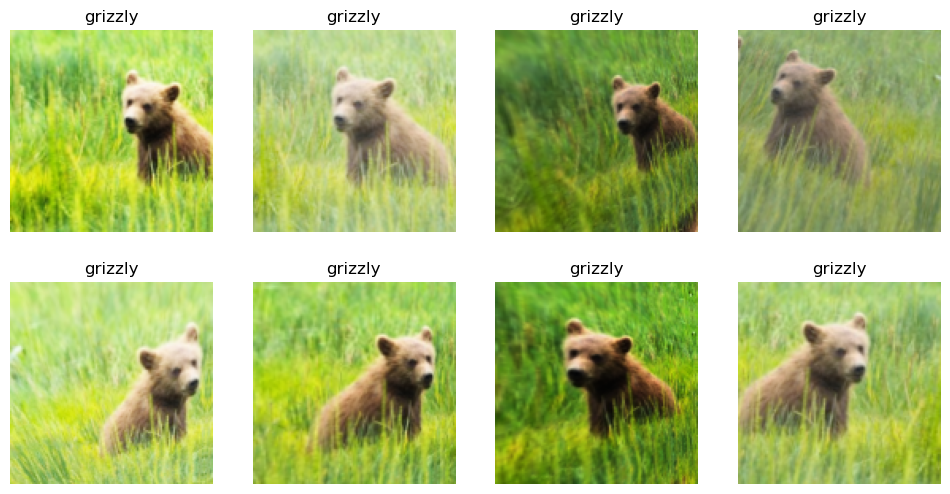

In [41]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Train our model

Time to use the same lines of code as in first notebook to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [42]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [43]:
# Check if the model is trained before, we just load it.
model_path= Path('bear.pkl')
model_existed=False

if model_path.exists():
    print(f"Loading existing model weights from: {model_path}")
    # Load the saved weights into the existing learner structure
    learn = load_learner('bear.pkl')
    learn.dls = dls
    model_existed=True
else:
    learn = vision_learner(dls, resnet18, metrics=error_rate)
    learn.fine_tune(4)
    model_existed= False

Loading existing model weights from: bear.pkl


## Investigate the model

In order to analyze the mistakes that model is making, one way is visualizing it.
To visualize this, we can create a *confusion matrix*:

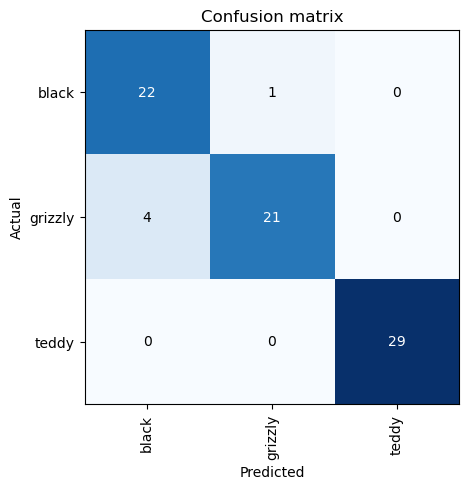

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their loss.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

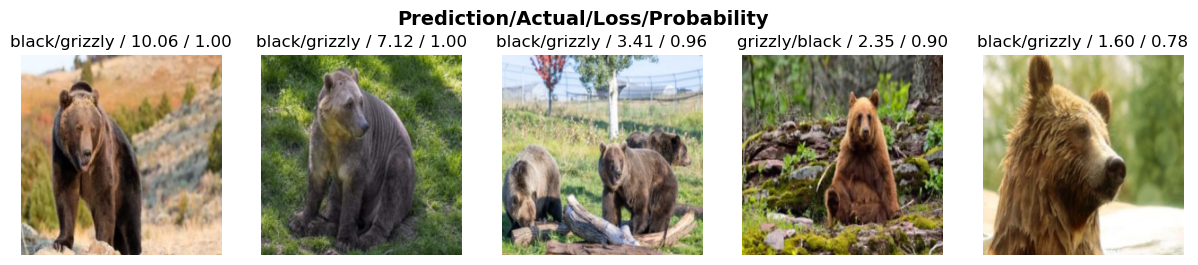

In [45]:
interp.plot_top_losses(5, nrows=1)

The intuitive approach to doing data cleaning is to do it before you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [46]:
#hide_output
if not model_existed:
    cleaner = ImageClassifierCleaner(learn)
    cleaner

## Turning the Model into an Online Application

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [47]:
if not model_existed:
    learn.export('bear.pkl')

For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing for demonstrating the end-to-end process):

In [48]:
if model_existed:    
    learn_inf = learn
else:
    learn_inf = load_learner('bear.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [49]:
learn_inf.predict('teddy_bear.jpg')

('teddy', tensor(2), tensor([3.5900e-07, 5.8539e-07, 1.0000e+00]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [50]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "teddy," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a teddy bear.

We know how to make predictions from our saved model, so we have everything we need to start building our app. We can do it directly in a Jupyter notebook.

### Creating a Notebook App from the Model

To use our model in an application, we can simply treat the `predict` method as a regular function. Therefore, creating an app from the model can be done using any of the myriad of frameworks and techniques available to application developers.

However, most data scientists are not familiar with the world of web application development. So let's try using something that you do, at this point, know: it turns out that we can create a complete working web application using nothing but Jupyter notebooks!

- IPython widgets (ipywidgets)

*IPython widgets* are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner that we saw earlier in this chapter is entirely written with IPython widgets. However, we don't want to require users of our application to run Jupyter themselves.

But we still have the advantage of developing in a notebook, so with ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier. First, we need a file upload widget:

In [51]:
btn_upload = widgets.FileUpload(accept='image/*', multiple=False)
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = None
    if not btn_upload.value:
        out_pl.clear_output()
        with out_pl:
            print("Please upload an image first.")
        lbl_pred.value = ""
        return

    try:        
        uploaded_file_info = btn_upload.value[0]        
        image_content_memoryview = uploaded_file_info['content']
        
        image_bytes = image_content_memoryview.tobytes()        
        img = PILImage.create(image_bytes)

    except Exception as e:
        out_pl.clear_output()
        with out_pl:
            print(f"Error loading image: {e}")
        lbl_pred.value = ""
        return
    
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128,128))

    pred, pred_idx, probs = learn_inf.predict(img)   
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

display(widgets.VBox([widgets.Label('Select your bear!'),
                      btn_upload, btn_run, out_pl, lbl_pred]))


## Serving model in Hugging face Space

This is a quick and easy way to serve the model for testing and serve it as Prototype.
Mostly it can be free as the model can be served using free CPU. There is a good integration with Gradio UI which makes it easier.

I pushed the model to this space: [Bear Classifier](https://huggingface.co/spaces/continuouslearnerforever/fastai-bear-classifier)

I found it very smooth and delightful experience of training the model and inspecting it. Then I prefer to serve it using `Gradio UI` for testing and verification as Prototype rather than using `IPython widgets`.

Serving the model via HF, has another advantage that simply it will be available via API. This is useful especially if the plan is to integerate the model serving inside an existing application or integrate it in a modern frontend application.

## How to Avoid Disaster

I found this section very important and wanted to repeat it again from the book.

In practice, a deep learning model will be just one piece of a much bigger system. As we discussed at the start of this chapter, a data product requires thinking about the entire end-to-end process, from conception to use in production. In this book, we can't hope to cover all the complexity of managing deployed data products, such as managing multiple versions of models, A/B testing, canarying, refreshing the data (should we just grow and grow our datasets all the time, or should we regularly remove some of the old data?), handling data labeling, monitoring all this, detecting model rot, and so forth. In this section we will give an overview of some of the most important issues to consider; for a more detailed discussion of deployment issues we refer to you to the excellent [Building Machine Learning Powered Applications](http://shop.oreilly.com/product/0636920215912.do) by Emmanuel Ameisen (O'Reilly)

One of the biggest issues to consider is that understanding and testing the behavior of a deep learning model is much more difficult than with most other code you write. With normal software development you can analyze the exact steps that the software is taking, and carefully study which of these steps match the desired behavior that you are trying to create. But with a neural network the behavior emerges from the model's attempt to match the training data, rather than being exactly defined.

This can result in disaster! For instance, let's say we really were rolling out a bear detection system that will be attached to video cameras around campsites in national parks, and will warn campers of incoming bears. If we used a model trained with the dataset we downloaded there would be all kinds of problems in practice, such as:

- Working with video data instead of images
- Handling nighttime images, which may not appear in this dataset
- Dealing with low-resolution camera images
- Ensuring results are returned fast enough to be useful in practice
- Recognizing bears in positions that are rarely seen in photos that people post online (for example from behind, partially covered by bushes, or when a long way away from the camera)

A big part of the issue is that the kinds of photos that people are most likely to upload to the internet are the kinds of photos that do a good job of clearly and artistically displaying their subject matter—which isn't the kind of input this system is going to be getting. So, we may need to do a lot of our own data collection and labelling to create a useful system.

This is just one example of the more general problem of *out-of-domain* data. That is to say, there may be data that our model sees in production which is very different to what it saw during training. There isn't really a complete technical solution to this problem; instead, we have to be careful about our approach to rolling out the technology.

There are other reasons we need to be careful too. One very common problem is *domain shift*, where the type of data that our model sees changes over time. For instance, an insurance company may use a deep learning model as part of its pricing and risk algorithm, but over time the types of customers that the company attracts, and the types of risks they represent, may change so much that the original training data is no longer relevant.

Out-of-domain data and domain shift are examples of a larger problem: that you can never fully understand the entire behaviour of your neural network. They have far too many parameters to be able to analytically understand all of their possible behaviors. This is the natural downside of their best feature—their flexibility, which enables them to solve complex problems where we may not even be able to fully specify our preferred solution approaches. The good news, however, is that there are ways to mitigate these risks using a carefully thought-out process. The details of this will vary depending on the details of the problem you are solving, but we will attempt to lay out here a high-level approach, summarized in <<deploy_process>>, which we hope will provide useful guidance.

<img alt="Deployment process" width="500" caption="Deployment process" id="deploy_process" src="./images/att_00061.png">

Where possible, the first step is to use an entirely manual process, with your deep learning model approach running in parallel but not being used directly to drive any actions. The humans involved in the manual process should look at the deep learning outputs and check whether they make sense. For instance, with our bear classifier a park ranger could have a screen displaying video feeds from all the cameras, with any possible bear sightings simply highlighted in red. The park ranger would still be expected to be just as alert as before the model was deployed; the model is simply helping to check for problems at this point.

The second step is to try to limit the scope of the model, and have it carefully supervised by people. For instance, do a small geographically and time-constrained trial of the model-driven approach. Rather than rolling our bear classifier out in every national park throughout the country, we could pick a single observation post, for a one-week period, and have a park ranger check each alert before it goes out.

Then, gradually increase the scope of your rollout. As you do so, ensure that you have really good reporting systems in place, to make sure that you are aware of any significant changes to the actions being taken compared to your manual process. For instance, if the number of bear alerts doubles or halves after rollout of the new system in some location, we should be very concerned. Try to think about all the ways in which your system could go wrong, and then think about what measure or report or picture could reflect that problem, and ensure that your regular reporting includes that information.

### Unforeseen Consequences and Feedback Loops

One of the biggest challenges in rolling out a model is that your model may change the behaviour of the system it is a part of. For instance, consider a "predictive policing" algorithm that predicts more crime in certain neighborhoods, causing more police officers to be sent to those neighborhoods, which can result in more crimes being recorded in those neighborhoods, and so on. In the Royal Statistical Society paper ["To Predict and Serve?"](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1740-9713.2016.00960.x), Kristian Lum and William Isaac observe that: "predictive policing is aptly named: it is predicting future policing, not future crime."

Part of the issue in this case is that in the presence of bias (which we'll discuss in depth in the next chapter), *feedback loops* can result in negative implications of that bias getting worse and worse. For instance, there are concerns that this is already happening in the US, where there is significant bias in arrest rates on racial grounds. [According to the ACLU](https://www.aclu.org/issues/smart-justice/sentencing-reform/war-marijuana-black-and-white), "despite roughly equal usage rates, Blacks are 3.73 times more likely than whites to be arrested for marijuana." The impact of this bias, along with the rollout of predictive policing algorithms in many parts of the US, led Bärí Williams to [write in the *New York Times*](https://www.nytimes.com/2017/12/02/opinion/sunday/intelligent-policing-and-my-innocent-children.html): "The same technology that’s the source of so much excitement in my career is being used in law enforcement in ways that could mean that in the coming years, my son, who is 7 now, is more likely to be profiled or arrested—or worse—for no reason other than his race and where we live."

A helpful exercise prior to rolling out a significant machine learning system is to consider this question: "What would happen if it went really, really well?" In other words, what if the predictive power was extremely high, and its ability to influence behavior was extremely significant? In that case, who would be most impacted? What would the most extreme results potentially look like? How would you know what was really going on?

Such a thought exercise might help you to construct a more careful rollout plan, with ongoing monitoring systems and human oversight. Of course, human oversight isn't useful if it isn't listened to, so make sure that there are reliable and resilient communication channels so that the right people will be aware of issues, and will have the power to fix them.

In [52]:
#| hide
import nbdev; nbdev.nbdev_export()